## Importing Required Libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -u "/content/gdrive/MyDrive/archive.zip" -d "/content"

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.models import Model

## Extracting Files

In [4]:
c = '/content/COVID-19_Radiography_Dataset/COVID/images'
n = '/content/COVID-19_Radiography_Dataset/Normal/images'
#c = '/Users/xiaolai/Desktop/MScProject/COVID19_Radiography_Dataset/data/COVID/images'
#n = '/Users/xiaolai/Desktop/MScProject/COVID19_Radiography_Dataset/data/Normal/images'

In [5]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n), 4000) # random select 4000 images for Normal

### Classes
* 0 -> Normal

* 1 -> COVID

In [6]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(1))
    else:
        categories.append(str(0))

## Converting to Dataframe

In [7]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [8]:
df.head()

,filename,category
0,/content/COVID-19_Radiography_Dataset/COVID/im...,1
1,/content/COVID-19_Radiography_Dataset/COVID/im...,1
2,/content/COVID-19_Radiography_Dataset/COVID/im...,1
3,/content/COVID-19_Radiography_Dataset/COVID/im...,1
4,/content/COVID-19_Radiography_Dataset/COVID/im...,1


## Exploratory Data Analysis

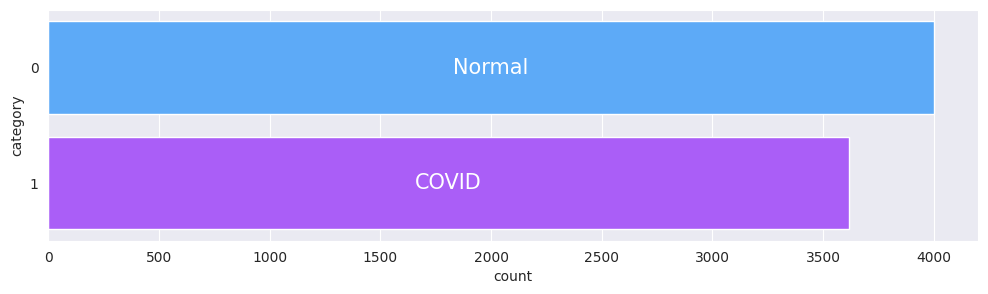

In [9]:
plt.figure(figsize=(12,3))
splot = sns.countplot(data = df.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0], 
              labels=['Normal', 'COVID'], 
              label_type='center', size=15, color='w')
plt.show()

## Data Visualization

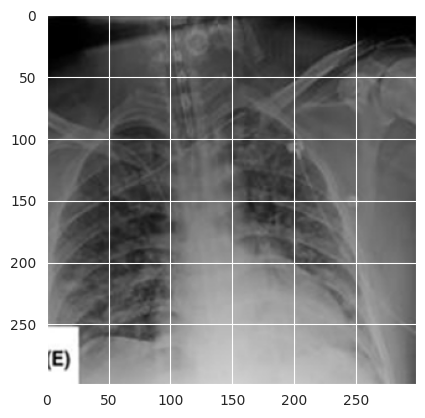

In [10]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

## Splitting Train, Validation & Test Data

In [11]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [12]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

## Data Augmentation

In [13]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [14]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 6092 validated image filenames belonging to 2 classes.


In [15]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

test_generator = valid_data_gen.flow_from_dataframe(
    test_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 762 validated image filenames belonging to 2 classes.
Found 762 validated image filenames belonging to 2 classes.


## Model Training - ResNet50

#### Model Architecture

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [16]:
baseModel = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

58889256/58889256 [==============================] - 4s 0us/step


#### Model Summary

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Optimizer - Adam

In [17]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
checkpoint = keras.callbacks.ModelCheckpoint("best_model",
                                            save_best_only=True)
#stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [20]:
epochs = 50
history = model.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=epochs, callbacks=[checkpoint])

Epoch 1/50
407/407 [==============================] - ETA: 0s - loss: 0.4638 - accuracy: 0.7841

407/407 [==============================] - 90s 196ms/step - loss: 0.4638 - accuracy: 0.7841 - val_loss: 0.3482 - val_accuracy: 0.8478
Epoch 2/50
407/407 [==============================] - ETA: 0s - loss: 0.3700 - accuracy: 0.8398

407/407 [==============================] - 74s 181ms/step - loss: 0.3700 - accuracy: 0.8398 - val_loss: 0.3140 - val_accuracy: 0.8609
Epoch 3/50
407/407 [==============================] - ETA: 0s - loss: 0.3333 - accuracy: 0.8549

407/407 [==============================] - 74s 181ms/step - loss: 0.3333 - accuracy: 0.8549 - val_loss: 0.2998 - val_accuracy: 0.8727
Epoch 4/50
407/407 [==============================] - ETA: 0s - loss: 0.3087 - accuracy: 0.8649

407/407 [==============================] - 73s 180ms/step - loss: 0.3087 - accuracy: 0.8649 - val_loss: 0.2815 - val_accuracy: 0.8701
Epoch 5/50
407/407 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.8731

407/407 [==============================] - 73s 180ms/step - loss: 0.2948 - accuracy: 0.8731 - val_loss: 0.2634 - val_accuracy: 0.8832
Epoch 6/50
407/407 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.8872

407/407 [==============================] - 74s 181ms/step - loss: 0.2737 - accuracy: 0.8872 - val_loss: 0.2579 - val_accuracy: 0.8911
Epoch 7/50
407/407 [==============================] - ETA: 0s - loss: 0.2673 - accuracy: 0.8889

407/407 [==============================] - 74s 181ms/step - loss: 0.2673 - accuracy: 0.8889 - val_loss: 0.2081 - val_accuracy: 0.9186
Epoch 8/50
407/407 [==============================] - 72s 176ms/step - loss: 0.2547 - accuracy: 0.8989 - val_loss: 0.2082 - val_accuracy: 0.9134
Epoch 9/50
407/407 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.8966

407/407 [==============================] - 74s 181ms/step - loss: 0.2513 - accuracy: 0.8966 - val_loss: 0.2032 - val_accuracy: 0.9213
Epoch 10/50
407/407 [==============================] - ETA: 0s - loss: 0.2423 - accuracy: 0.8995

407/407 [==============================] - 74s 182ms/step - loss: 0.2423 - accuracy: 0.8995 - val_loss: 0.1961 - val_accuracy: 0.9186
Epoch 11/50
407/407 [==============================] - ETA: 0s - loss: 0.2335 - accuracy: 0.9053

407/407 [==============================] - 73s 179ms/step - loss: 0.2335 - accuracy: 0.9053 - val_loss: 0.1724 - val_accuracy: 0.9436
Epoch 12/50
407/407 [==============================] - 71s 174ms/step - loss: 0.2285 - accuracy: 0.9048 - val_loss: 0.1926 - val_accuracy: 0.9278
Epoch 13/50
407/407 [==============================] - 70s 173ms/step - loss: 0.2296 - accuracy: 0.9045 - val_loss: 0.1754 - val_accuracy: 0.9409
Epoch 14/50
407/407 [==============================] - 71s 174ms/step - loss: 0.2229 - accuracy: 0.9066 - val_loss: 0.1936 - val_accuracy: 0.9173
Epoch 15/50
407/407 [==============================] - ETA: 0s - loss: 0.2092 - accuracy: 0.9107

407/407 [==============================] - 73s 179ms/step - loss: 0.2092 - accuracy: 0.9107 - val_loss: 0.1639 - val_accuracy: 0.9449
Epoch 16/50
407/407 [==============================] - 71s 175ms/step - loss: 0.2147 - accuracy: 0.9086 - val_loss: 0.1738 - val_accuracy: 0.9331
Epoch 17/50
407/407 [==============================] - 71s 174ms/step - loss: 0.2001 - accuracy: 0.9219 - val_loss: 0.1647 - val_accuracy: 0.9409
Epoch 18/50
407/407 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 0.9161

407/407 [==============================] - 73s 179ms/step - loss: 0.2000 - accuracy: 0.9161 - val_loss: 0.1565 - val_accuracy: 0.9449
Epoch 19/50
407/407 [==============================] - 71s 173ms/step - loss: 0.1973 - accuracy: 0.9197 - val_loss: 0.1657 - val_accuracy: 0.9357
Epoch 20/50
407/407 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.9163

407/407 [==============================] - 73s 179ms/step - loss: 0.2014 - accuracy: 0.9163 - val_loss: 0.1492 - val_accuracy: 0.9449
Epoch 21/50
407/407 [==============================] - 71s 174ms/step - loss: 0.1909 - accuracy: 0.9251 - val_loss: 0.1492 - val_accuracy: 0.9475
Epoch 22/50
407/407 [==============================] - 71s 174ms/step - loss: 0.1887 - accuracy: 0.9237 - val_loss: 0.1723 - val_accuracy: 0.9318
Epoch 23/50
407/407 [==============================] - 71s 174ms/step - loss: 0.1866 - accuracy: 0.9242 - val_loss: 0.1889 - val_accuracy: 0.9226
Epoch 24/50
407/407 [==============================] - 71s 174ms/step - loss: 0.1952 - accuracy: 0.9219 - val_loss: 0.1556 - val_accuracy: 0.9449
Epoch 25/50
407/407 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 0.9276

407/407 [==============================] - 72s 178ms/step - loss: 0.1813 - accuracy: 0.9276 - val_loss: 0.1414 - val_accuracy: 0.9514
Epoch 26/50
407/407 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9228

407/407 [==============================] - 73s 179ms/step - loss: 0.1887 - accuracy: 0.9228 - val_loss: 0.1362 - val_accuracy: 0.9567
Epoch 27/50
407/407 [==============================] - 71s 174ms/step - loss: 0.1787 - accuracy: 0.9256 - val_loss: 0.1470 - val_accuracy: 0.9436
Epoch 28/50
407/407 [==============================] - ETA: 0s - loss: 0.1749 - accuracy: 0.9296

407/407 [==============================] - 73s 179ms/step - loss: 0.1749 - accuracy: 0.9296 - val_loss: 0.1334 - val_accuracy: 0.9567
Epoch 29/50
407/407 [==============================] - 71s 173ms/step - loss: 0.1736 - accuracy: 0.9279 - val_loss: 0.1365 - val_accuracy: 0.9462
Epoch 30/50
407/407 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.9314

407/407 [==============================] - 73s 179ms/step - loss: 0.1710 - accuracy: 0.9314 - val_loss: 0.1299 - val_accuracy: 0.9593
Epoch 31/50
407/407 [==============================] - 71s 173ms/step - loss: 0.1701 - accuracy: 0.9299 - val_loss: 0.1622 - val_accuracy: 0.9370
Epoch 32/50
407/407 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9288

407/407 [==============================] - 73s 179ms/step - loss: 0.1720 - accuracy: 0.9288 - val_loss: 0.1245 - val_accuracy: 0.9580
Epoch 33/50
407/407 [==============================] - 70s 173ms/step - loss: 0.1693 - accuracy: 0.9322 - val_loss: 0.1614 - val_accuracy: 0.9265
Epoch 34/50
407/407 [==============================] - 71s 174ms/step - loss: 0.1704 - accuracy: 0.9302 - val_loss: 0.1272 - val_accuracy: 0.9606
Epoch 35/50
407/407 [==============================] - 71s 174ms/step - loss: 0.1663 - accuracy: 0.9325 - val_loss: 0.1358 - val_accuracy: 0.9541
Epoch 36/50
407/407 [==============================] - 71s 175ms/step - loss: 0.1556 - accuracy: 0.9383 - val_loss: 0.1825 - val_accuracy: 0.9160
Epoch 37/50
407/407 [==============================] - 71s 175ms/step - loss: 0.1582 - accuracy: 0.9360 - val_loss: 0.1277 - val_accuracy: 0.9554
Epoch 38/50
407/407 [==============================] - 71s 174ms/step - loss: 0.1630 - accuracy: 0.9381 - val_loss: 0.1578 - val_accurac

407/407 [==============================] - 73s 178ms/step - loss: 0.1547 - accuracy: 0.9419 - val_loss: 0.1236 - val_accuracy: 0.9593
Epoch 42/50
407/407 [==============================] - 71s 174ms/step - loss: 0.1550 - accuracy: 0.9383 - val_loss: 0.1295 - val_accuracy: 0.9606
Epoch 43/50
407/407 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9399

407/407 [==============================] - 73s 180ms/step - loss: 0.1581 - accuracy: 0.9399 - val_loss: 0.1173 - val_accuracy: 0.9659
Epoch 44/50
407/407 [==============================] - ETA: 0s - loss: 0.1449 - accuracy: 0.9402

407/407 [==============================] - 73s 179ms/step - loss: 0.1449 - accuracy: 0.9402 - val_loss: 0.1091 - val_accuracy: 0.9633
Epoch 45/50
407/407 [==============================] - 71s 174ms/step - loss: 0.1489 - accuracy: 0.9429 - val_loss: 0.1169 - val_accuracy: 0.9567
Epoch 46/50
407/407 [==============================] - 71s 174ms/step - loss: 0.1430 - accuracy: 0.9409 - val_loss: 0.1102 - val_accuracy: 0.9659
Epoch 47/50
407/407 [==============================] - 71s 175ms/step - loss: 0.1354 - accuracy: 0.9476 - val_loss: 0.1271 - val_accuracy: 0.9528
Epoch 48/50
407/407 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.9386

407/407 [==============================] - 73s 179ms/step - loss: 0.1488 - accuracy: 0.9386 - val_loss: 0.1027 - val_accuracy: 0.9698
Epoch 49/50
407/407 [==============================] - 71s 174ms/step - loss: 0.1362 - accuracy: 0.9453 - val_loss: 0.1121 - val_accuracy: 0.9567
Epoch 50/50
407/407 [==============================] - 71s 173ms/step - loss: 0.1369 - accuracy: 0.9448 - val_loss: 0.1632 - val_accuracy: 0.9239


## Saving Model

In [23]:
model.save('/content/gdrive/MyDrive//VGG16_12042023.h5')

In [24]:
#import shutil
%cp -av "/content/best_model" "/content/gdrive/MyDrive/VGG16/"

'/content/best_model' -> '/content/gdrive/MyDrive/VGG16/best_model'
'/content/best_model/variables' -> '/content/gdrive/MyDrive/VGG16/best_model/variables'
'/content/best_model/variables/variables.index' -> '/content/gdrive/MyDrive/VGG16/best_model/variables/variables.index'
'/content/best_model/variables/variables.data-00000-of-00001' -> '/content/gdrive/MyDrive/VGG16/best_model/variables/variables.data-00000-of-00001'
'/content/best_model/assets' -> '/content/gdrive/MyDrive/VGG16/best_model/assets'
'/content/best_model/fingerprint.pb' -> '/content/gdrive/MyDrive/VGG16/best_model/fingerprint.pb'
'/content/best_model/saved_model.pb' -> '/content/gdrive/MyDrive/VGG16/best_model/saved_model.pb'
'/content/best_model/keras_metadata.pb' -> '/content/gdrive/MyDrive/VGG16/best_model/keras_metadata.pb'


## Model Evaluation


In [25]:
model.evaluate(train_generator)
model.evaluate(valid_generator)


51/51 [==============================] - 3s 62ms/step - loss: 0.1632 - accuracy: 0.9239


[0.1631575971841812, 0.9238845109939575]

In [26]:
# create history loss and accuracy function
def plot_loss_acc(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(train_loss))

    plt.figure(figsize=(8,6))
    plt.plot(epochs, train_loss, color='b', label='Train')
    plt.plot(epochs, val_loss, color='r', label='Validation')
    plt.legend()
    plt.title('Model Loss')
    
    
    plt.figure(figsize=(8,6))
    plt.plot(epochs, acc, color='b', label='Train')
    plt.plot(epochs, val_acc, color='r', label='Validation')
    plt.legend()
    plt.title('Model Accuracy')
    
    plt.show()

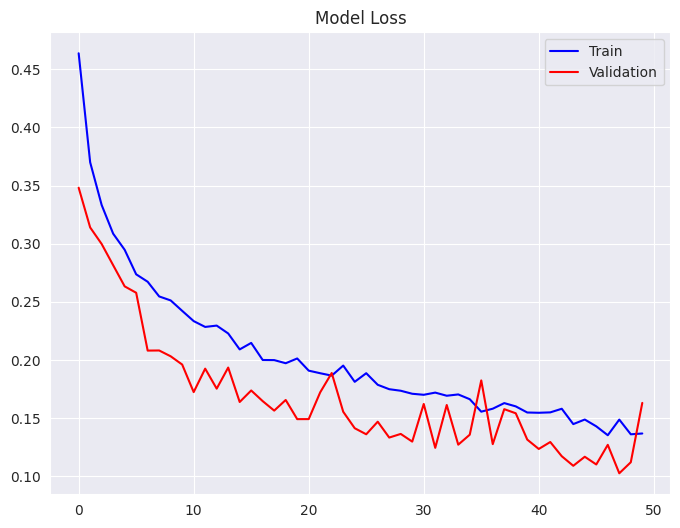

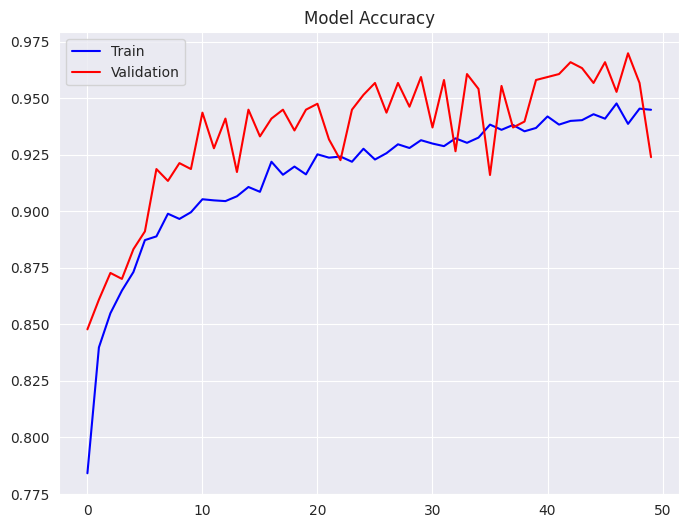

In [27]:
plot_loss_acc(history)

## Classificaiton Confusion Matrix

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [29]:
# predict classes of validation dataset
test_predict = model.predict(test_generator)

51/51 [==============================] - 3s 61ms/step


In [30]:
predict_class = np.argmax(test_predict, axis=1)
predict_class = predict_class.tolist()

In [31]:
labels = ['COVID', 'Normal']
report = classification_report(test_generator.classes, predict_class, target_names=labels)
print(report)

              precision    recall  f1-score   support

       COVID       0.55      0.61      0.58       400
      Normal       0.51      0.44      0.47       362

    accuracy                           0.53       762
   macro avg       0.53      0.53      0.52       762
weighted avg       0.53      0.53      0.53       762



In [32]:
cm = confusion_matrix(test_generator.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['COVID','NORMAL'], 
                     columns = ['COVID','NORMAL'])

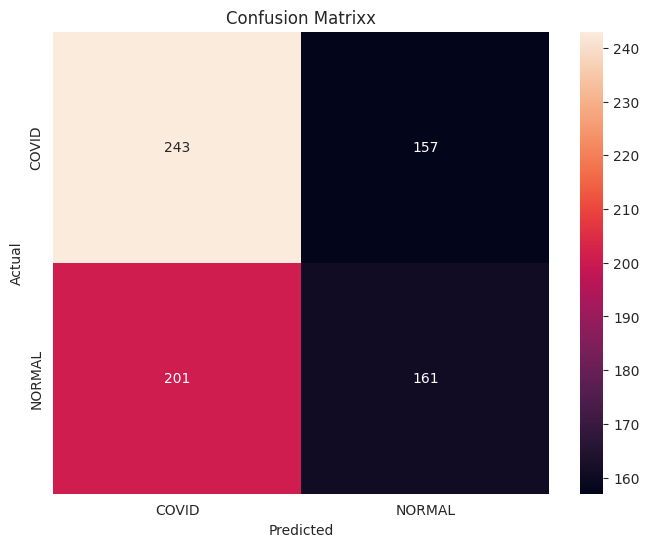

In [33]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Test External data

In [37]:
random.seed(42)
c2 = '/content/gdrive/MyDrive/dataset/COVID'
filenames2 = os.listdir(c2)

categories = []
for filename in filenames2:
    category = filename.split('-')[0]
    categories.append(str(1))


for i in range(len(filenames2)):
      filenames2[i] = os.path.join(c2, filenames2[i])
    
    
df2 = pd.DataFrame({
    'filename': filenames2,
    'category': categories
})

In [38]:
random.seed(42)
n2 = '/content/gdrive/MyDrive/dataset/Normal'
filenames3 = os.listdir(n2)

categories = []
for filename in filenames3:
    category = filename.split('-')[0]
    categories.append(str(0))


for i in range(len(filenames3)):
      filenames3[i] = os.path.join(n2, filenames3[i])
    
    
df3 = pd.DataFrame({
    'filename': filenames3,
    'category': categories
})

In [39]:
df2.head()

,filename,category
0,/content/gdrive/MyDrive/dataset/COVID/covid (3...,1
1,/content/gdrive/MyDrive/dataset/COVID/covid (2...,1
2,/content/gdrive/MyDrive/dataset/COVID/covid (2...,1
3,/content/gdrive/MyDrive/dataset/COVID/covid (2...,1
4,/content/gdrive/MyDrive/dataset/COVID/covid (1...,1


In [40]:
df3.head()

,filename,category
0,/content/gdrive/MyDrive/dataset/Normal/IM-0234...,0
1,/content/gdrive/MyDrive/dataset/Normal/IM-0227...,0
2,/content/gdrive/MyDrive/dataset/Normal/IM-0226...,0
3,/content/gdrive/MyDrive/dataset/Normal/IM-0248...,0
4,/content/gdrive/MyDrive/dataset/Normal/IM-0265...,0


In [41]:
frames = [df2, df3]

test2 = pd.concat(frames)

In [42]:
test2.head()

,filename,category
0,/content/gdrive/MyDrive/dataset/COVID/covid (3...,1
1,/content/gdrive/MyDrive/dataset/COVID/covid (2...,1
2,/content/gdrive/MyDrive/dataset/COVID/covid (2...,1
3,/content/gdrive/MyDrive/dataset/COVID/covid (2...,1
4,/content/gdrive/MyDrive/dataset/COVID/covid (1...,1


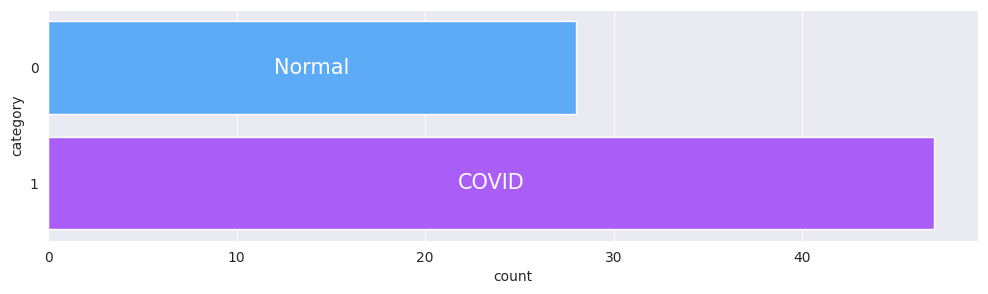

In [43]:
plt.figure(figsize=(12,3))
splot = sns.countplot(data = test2.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0], 
              labels=['Normal', 'COVID'], 
              label_type='center', size=15, color='w')
plt.show()

In [44]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

test2_generator = valid_data_gen.flow_from_dataframe(
    test2, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 75 validated image filenames belonging to 2 classes.


## Classificaiton Confusion Matrix

In [46]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive//VGG16_12042023.h5')

In [47]:
# predict classes of validation dataset
test_predict = model.predict(test2_generator)

5/5 [==============================] - 44s 11s/step


In [48]:
predict_class = np.argmax(test_predict, axis=1)
predict_class = predict_class.tolist()

In [49]:
labels = ['COVID', 'Normal']
report = classification_report(test2_generator.classes, predict_class, target_names=labels)
print(report)

              precision    recall  f1-score   support

       COVID       0.31      0.39      0.34        28
      Normal       0.56      0.47      0.51        47

    accuracy                           0.44        75
   macro avg       0.43      0.43      0.43        75
weighted avg       0.47      0.44      0.45        75



In [50]:
cm = confusion_matrix(test2_generator.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['COVID','NORMAL'], 
                     columns = ['COVID','NORMAL'])

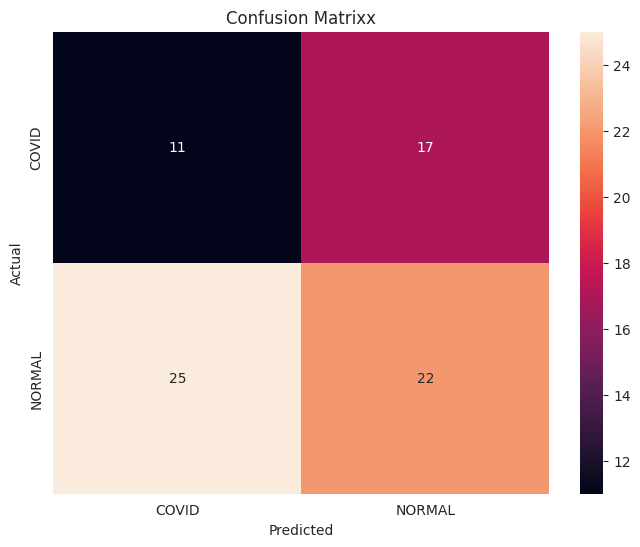

In [51]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()